## Instructions
### Banking Marketing Campaign
### Business Insight

Long-term deposits allow banks to hold money for a specific period of time, allowing the bank to use that money to enhance its investments. Marketing campaigns for this product are based on phone calls. If a user is not available at a given time, then they will be called back at another time.

### Description of the problem

The Portuguese bank is experiencing a decline in revenue, so they want to be able to identify existing customers who are more likely to take out a long-term deposit. This will allow the bank to focus their marketing efforts on those customers and avoid wasting money and time on customers who are unlikely to sign up.

To address this problem we will create a ranking algorithm to help predict whether or not a customer will sign up for a long-term deposit.

In [1]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# When you work locally it is likely to have an error with the SSL certification
# Recomend use request for read csv
import requests
from io import StringIO

from sklearn.preprocessing import (MinMaxScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import (chi2,
                                       SelectKBest)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Step 1: Import DB

In [2]:
# Import DB
url = "https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv"
response = requests.get(url)
# Data in CSV file is separated by semicolon (;) instead of comma (,)
df = pd.read_csv(StringIO(response.text), sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Create DB file in data/raw
df_raw = df.copy()
df_raw.to_csv("../data/raw/df_raw_ML.csv", index= False)

In [4]:
display(df_raw.info())
display(df_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

None

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Step 2: Preprocessing

In [5]:
# Create df_interim_ML
df_interim = (
    df_raw
        .copy()
        .set_axis(
            df_raw.columns.str.replace(' ','_')
                          .str.replace('r\W','', regex= True)
                          .str.lower()
                          .str.slice(0, 40), axis= 1
        )
        .drop_duplicates().reset_index(drop= True)
        .astype({'job': 'category',
                 'marital': 'category',
                 'education': 'category',
                 'default': 'category',
                 'housing': 'category',
                 'loan': 'category',
                 'contact': 'category',
                 'month': 'category',
                 'day_of_week': 'category',
                 'poutcome': 'category',
                 'y': 'category'
                 })
)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41176 non-null  int64   
 1   job             41176 non-null  category
 2   marital         41176 non-null  category
 3   education       41176 non-null  category
 4   default         41176 non-null  category
 5   housing         41176 non-null  category
 6   loan            41176 non-null  category
 7   contact         41176 non-null  category
 8   month           41176 non-null  category
 9   day_of_week     41176 non-null  category
 10  duration        41176 non-null  int64   
 11  campaign        41176 non-null  int64   
 12  pdays           41176 non-null  int64   
 13  previous        41176 non-null  int64   
 14  poutcome        41176 non-null  category
 15  emp.varate      41176 non-null  float64 
 16  cons.price.idx  41176 non-null  float64 
 17  cons.conf.id

In [6]:
df_interim.rename(columns= {'y': 'target'}, inplace= True)
cols = ['target'] + [col for col in df_interim.columns if col != 'target']
df_interim = df_interim[cols]

df_interim.head()

,target,age,job,marital,education,default,housing,loan,contact,month,...,duration,campaign,pdays,previous,poutcome,emp.varate,cons.price.idx,cons.conf.idx,euribor3m,nemployed
0,no,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,no,57,services,married,high.school,unknown,no,no,telephone,may,...,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,no,37,services,married,high.school,no,yes,no,telephone,may,...,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,no,40,admin.,married,basic.6y,no,no,no,telephone,may,...,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,no,56,services,married,high.school,no,no,yes,telephone,may,...,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [7]:
# Create DB interim in ../data/interim
df_interim.to_csv("../data/interim/df_interim_ML.csv", index= False)

In [8]:
df = df_interim.copy()

### Step 3: EDA

In [9]:
df_train, df_test = train_test_split(df, test_size= 0.2, random_state=2024, stratify= df['target'])

In [10]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,32940.0,40.023983,10.429740,17.000,32.000,38.000,47.000,98.000
duration,32940.0,258.344839,258.576750,0.000,102.000,179.000,319.000,4199.000
campaign,32940.0,2.569581,2.771763,1.000,1.000,2.000,3.000,56.000
pdays,32940.0,963.034942,185.533260,0.000,999.000,999.000,999.000,999.000
previous,32940.0,0.171736,0.492251,0.000,0.000,0.000,0.000,7.000
emp.varate,32940.0,0.078157,1.572298,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,32940.0,93.575732,0.580033,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,32940.0,-40.510583,4.631935,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,32940.0,3.616963,1.735927,0.634,1.344,4.857,4.961,5.045
nemployed,32940.0,5166.855431,72.383602,4963.600,5099.100,5191.000,5228.100,5228.100


,count,unique,top,freq
target,32940,2,no,29229
job,32940,12,admin.,8291
marital,32940,4,married,19940
education,32940,8,university.degree,9676
default,32940,3,no,26024
housing,32940,3,yes,17310
loan,32940,3,no,27180
contact,32940,2,cellular,20900
month,32940,10,may,10969
day_of_week,32940,5,thu,6911


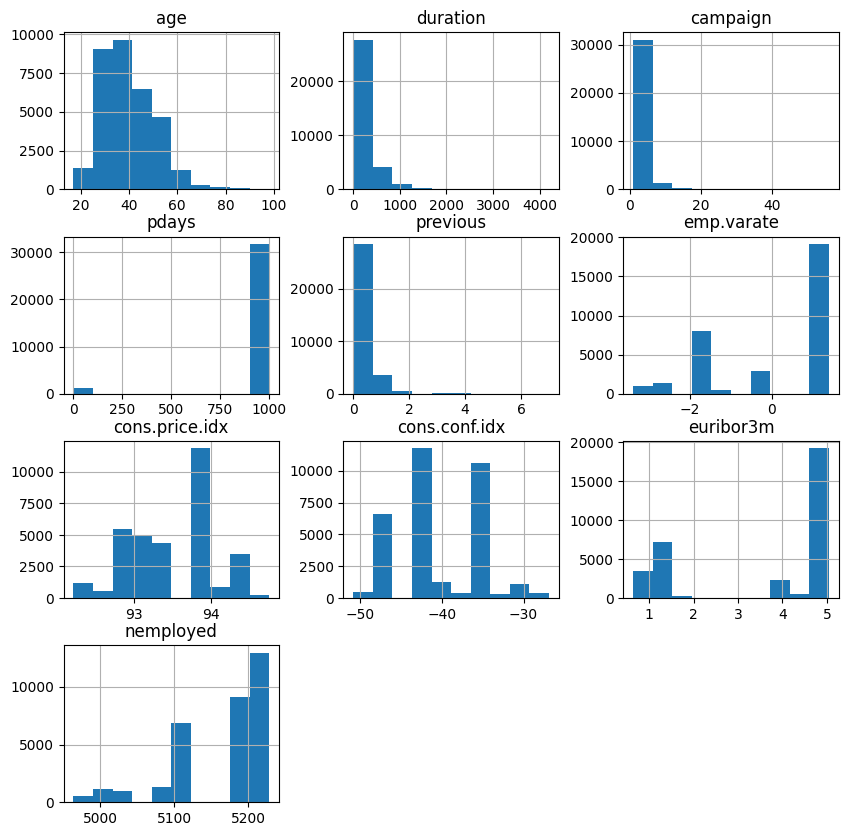

In [11]:
# Step 3.1: Univariate analysis
df_train.hist(figsize= (10,10))
plt.show()

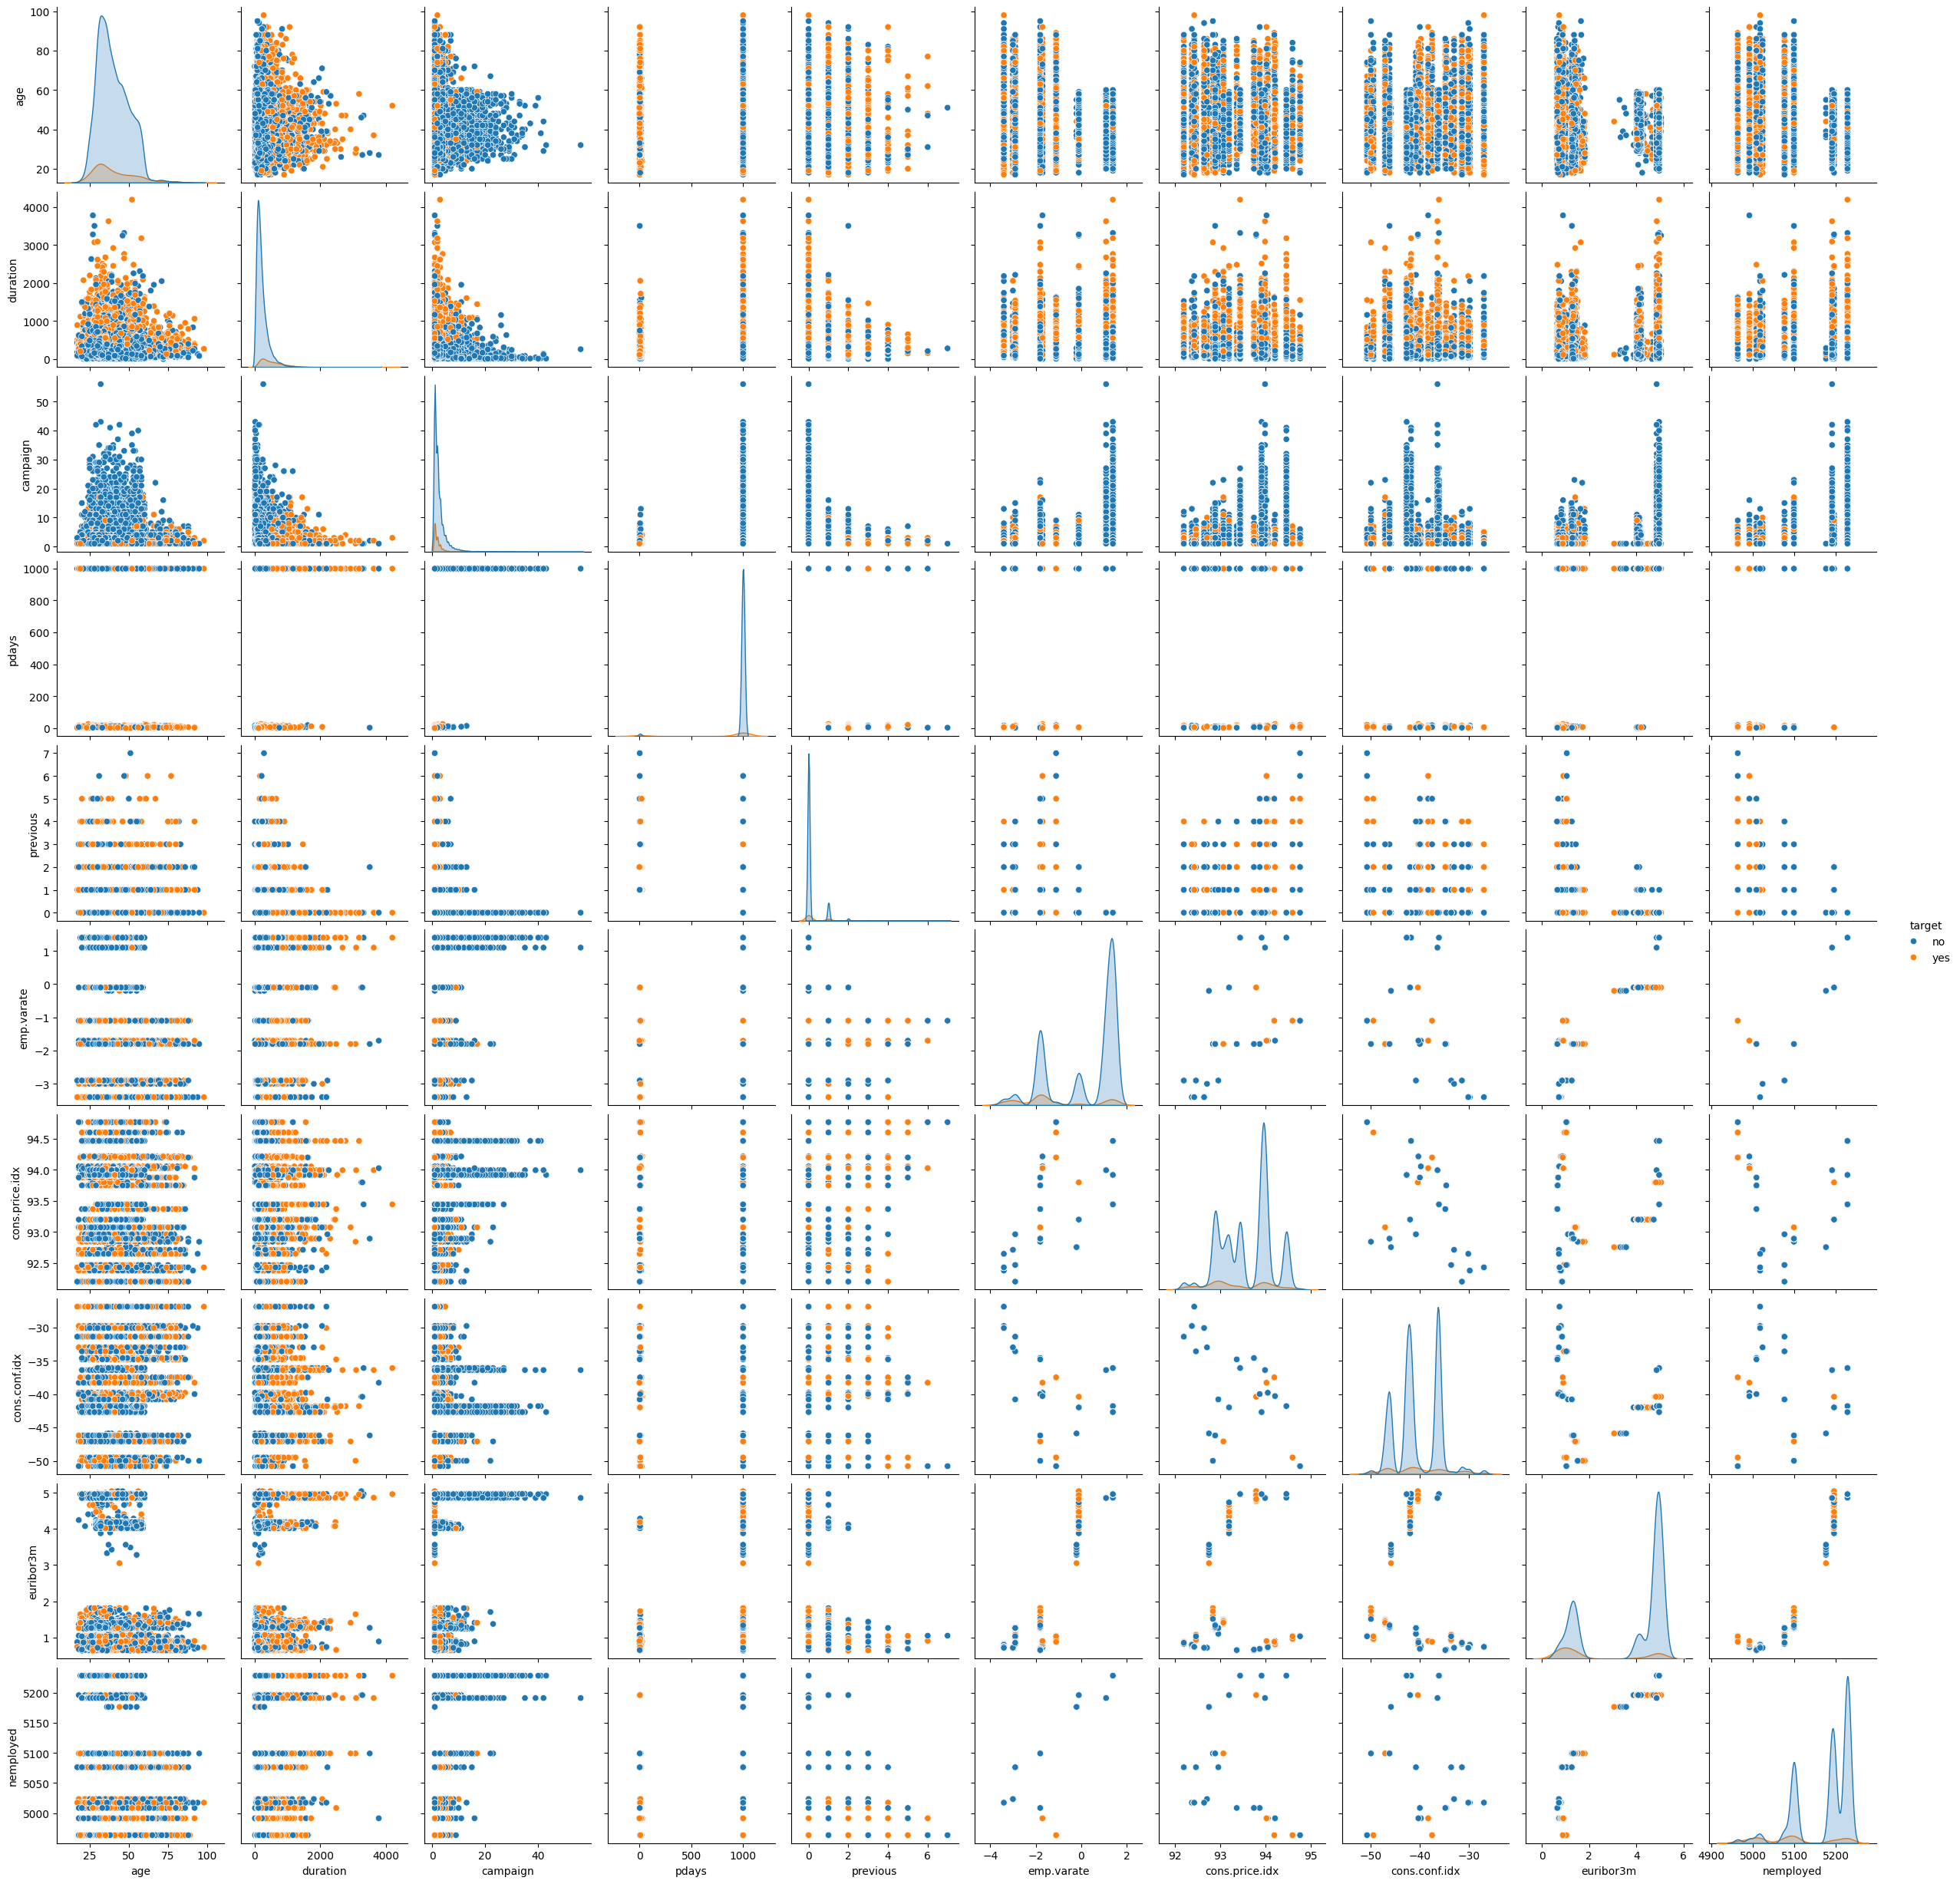

In [12]:
# Step 3.2: Bivariate analysis
sns.pairplot(data= df_train, hue= 'target')
plt.show()

- Linear relationships between features are not very strong
- Possible outliers are observed in some variables, such as duration or campaign, where some points are very far from the rest

In [13]:
df_train.select_dtypes('number').corr()

,age,duration,campaign,pdays,previous,emp.varate,cons.price.idx,cons.conf.idx,euribor3m,nemployed
age,1.000000,-0.001573,0.005614,-0.030532,0.024932,0.000740,0.002012,0.130677,0.012023,-0.016855
duration,-0.001573,1.000000,-0.071825,-0.045184,0.017642,-0.026588,0.007642,-0.008121,-0.032162,-0.044008
campaign,0.005614,-0.071825,1.000000,0.052869,-0.079727,0.155062,0.129969,-0.011684,0.139568,0.148006
pdays,-0.030532,-0.045184,0.052869,1.000000,-0.582026,0.267967,0.078871,-0.090110,0.293032,0.367635
previous,0.024932,0.017642,-0.079727,-0.582026,1.000000,-0.417207,-0.199513,-0.056143,-0.451765,-0.498476
emp.varate,0.000740,-0.026588,0.155062,0.267967,-0.417207,1.000000,0.775098,0.193917,0.972202,0.906482
cons.price.idx,0.002012,0.007642,0.129969,0.078871,-0.199513,0.775098,1.000000,0.056386,0.687371,0.520553
cons.conf.idx,0.130677,-0.008121,-0.011684,-0.090110,-0.056143,0.193917,0.056386,1.000000,0.275696,0.099412
euribor3m,0.012023,-0.032162,0.139568,0.293032,-0.451765,0.972202,0.687371,0.275696,1.000000,0.945091
nemployed,-0.016855,-0.044008,0.148006,0.367635,-0.498476,0.906482,0.520553,0.099412,0.945091,1.000000


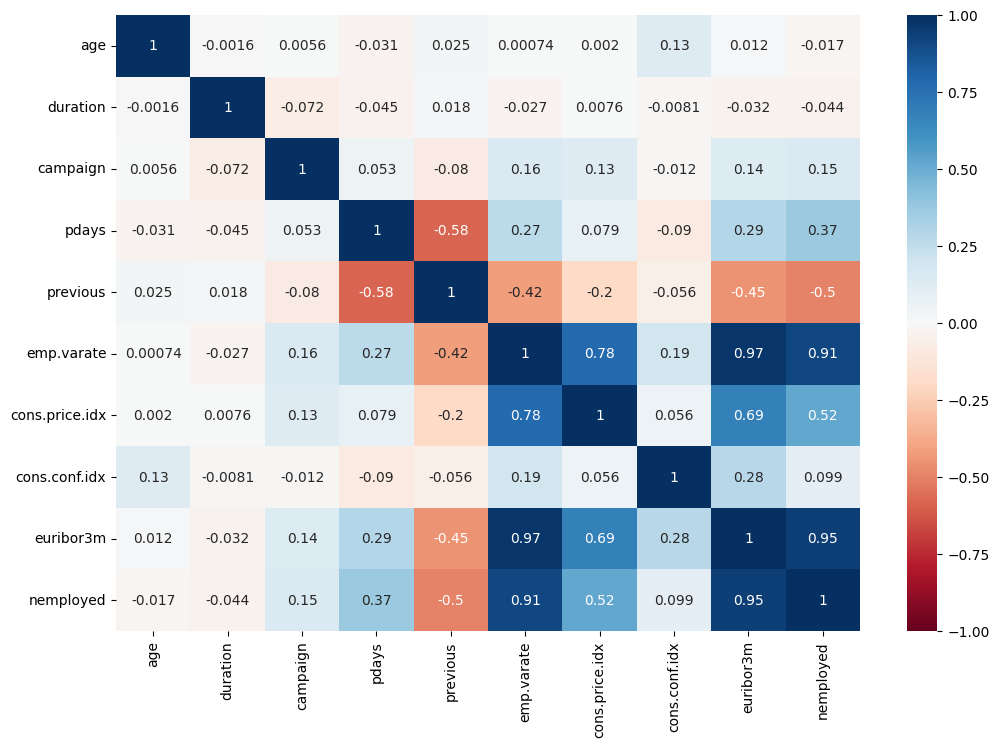

In [14]:
plt.figure(figsize= (12, 8))
sns.heatmap(df_train.select_dtypes('number').corr(), vmin= -1, vmax= 1, annot= True, cmap= 'RdBu')
plt.show()

#### Correlation is observed between:
- euriborn3m vs nemployed (strong)
- emp.varate vs nemployed (strong)
- emp.varate vs euriborn3m (strong)
- cons.con.idx vs emp.varate (medium)
- cons.conf.idx vs euriborn3m (medium)

In [15]:
# Split data
X_train = df_train.drop('target', axis=1).reset_index(drop= True)
y_train = df_train['target'].reset_index(drop= True)
X_test = df_test.drop('target', axis=1).reset_index(drop= True)
y_test = df_test['target'].reset_index(drop= True)

In [ ]:
display(df_train.columns)

In [48]:
# Identify categorical and number columns
cat_cols = X_train.select_dtypes('category').columns
num_cols = X_train.select_dtypes('number').columns

# Pipelines for categorycals and number variables
cat_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])
num_proc = Pipeline([
    ('nimputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
# ColumnTransformer for Pipelines
processor = ColumnTransformer([
    ('cat', cat_proc, cat_cols),
    ('num', num_proc, num_cols)
])

In [49]:
# Apply the processor to df train
X_train_clean = processor.fit_transform(X_train, y_train)

In [50]:
# Apply the processor to df train
X_test_clean = processor.transform(X_test)

In [51]:
selector = SelectKBest(chi2, k=5)
X_train_sel = selector.fit_transform(X_train_clean, y_train)
X_test_sel = selector.transform(X_test_clean)

In [54]:
# Get name columns transformers
onehot_columns = processor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
# Concat names
column_names = list(onehot_columns) + list(num_cols)
# Apply SelectKBest to selected columns
selected_columns = selector.get_support(indices=True)
column_names_selected = [column_names[i] for i in selected_columns]

df_clean_train = pd.DataFrame(X_train_sel, columns=column_names_selected)
display(df_clean_train.head())

df_clean_test = pd.DataFrame(X_test_sel, columns=column_names_selected)
display(df_clean_test.head())

,month_mar,month_oct,month_sep,poutcome_success,euribor3m
0,0.0,0.0,0.0,0.0,0.980503
1,0.0,0.0,0.0,0.0,0.981637
2,0.0,0.0,0.0,0.0,0.980730
3,0.0,1.0,0.0,0.0,1.000000
4,0.0,0.0,0.0,0.0,0.790297


,month_mar,month_oct,month_sep,poutcome_success,euribor3m
0,0.0,0.0,0.0,0.0,0.957606
1,0.0,0.0,0.0,0.0,0.980503
2,0.0,0.0,0.0,0.0,0.980503
3,0.0,0.0,0.0,0.0,0.981410
4,0.0,0.0,0.0,0.0,0.959193


In [56]:
# Create DB to ../data/processed/
df_clean_train["target"] = list(y_train)
df_clean_test["target"] = list(y_test)
df_clean_train.to_csv("../data/processed/df_train_clean_ML.csv", index = False)
df_clean_test.to_csv("../data/processed/df_test_clean_ML.csv", index = False)